In [1]:
import pandas as pd
import numpy as np
import joblib
import gc
import warnings

# Model eğitimi, veri ölçekleme ve başarı skorlarını ölçmek için gereken sklearn araçlarını çağırdım
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Kod çalışırken çıkan gereksiz uyarıları gizledim ve belleği temizledim ki ram şişmesin
warnings.filterwarnings("ignore")
gc.collect()

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


In [2]:
print("Veri yükleniyor (Chunking Yöntemi)...")

# Modelde kullanacağım özellikleri ve tahmin etmeye çalıştığım hedef sütunu burada seçtim, gereksizleri almayacağım
FEATURES = [
    'LOCATION_TYPE', 
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 
    'ROAD_TYPE_LOCAL_MAIN_ROADS', 
    'ROAD_TYPE_SPECIAL_AREAS'
]
TARGET = "SEVERITY"
cols_to_use = FEATURES + [TARGET]

# Veriyi parça parça okuyacağım için boş bir liste hazırladım, tipleri de baştan float32 yaptım ki hata vermesin
chunks = []
dtype_dict = {col: 'float32' for col in cols_to_use}

try:
    # Dosya çok büyük olduğu için 50 binlik parçalar halinde okuyorum. Boş verileri atıp veriyi küçültüyorum
    for chunk in pd.read_csv("NYC_Crash_Model_Final_Last.csv", usecols=cols_to_use, chunksize=50000, dtype=dtype_dict):
        chunk = chunk.dropna()
        for col in chunk.columns:
            chunk[col] = chunk[col].astype('int8') # Bellek tasarrufu
        chunks.append(chunk)

    # Parçaları birleştirip tek bir dataframe yaptım, işim biten listeyi de sildim
    df_model = pd.concat(chunks, axis=0)
    del chunks
    gc.collect()

    # Eğitimde kullanacağım X ve y verilerini ayırdım
    X = df_model[FEATURES]
    y = df_model[TARGET]
    
    print(f"Veri Hazır: {X.shape} satır.")

except Exception as e:
    print(f"Hata: {e}")

Veri yükleniyor (Chunking Yöntemi)...
Veri Hazır: (1911073, 4) satır.


In [3]:
# --- HÜCRE 3: SPLIT VE SCALING ---

# Veriyi train ve test olarak ikiye böldüm, yüzde 20'sini test için kenara ayırdım. Oranlar bozulmasın diye stratify kullandım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Veriler arasındaki uçurumları engellemek için standartlaştırma yaptım. Train verisine göre ölçekleyip aynısını teste uyguladım
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Veri ayrıldı ve ölçeklendi.")

Veri ayrıldı ve ölçeklendi.


In [4]:
c_values = [0.01, 0.1, 1, 10, 100]  
# Buraya senin istediğin o 'ara değerleri' de ekledim (1:3 ve 1:4 kritikti)
weights = [None, 'balanced', {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5}] 

# Sonuçları saklayacağım boş listeyi oluşturdum
results = []

# Ekranda düzgün bir tablo görmek için başlıkları ayarlayıp yazdırdım
print(f"{'C Değeri':<10} | {'Ağırlık (Weight)':<20} | {'Recall':<10} | {'Precision':<10} | {'F1':<10} | {'Accuracy':<10}")
print("-" * 90)

# Tüm C değerlerini ve ağırlık kombinasyonlarını tek tek denemek için döngü kurdum
for c in c_values:
    for w in weights:
        # Modeli belirlediğim parametrelerle kurdum, solver olarak liblinear kullandım
        model = LogisticRegression(C=c, class_weight=w, solver='liblinear', random_state=42)
        
        # Modeli ölçeklenmiş veriyle eğitip test verisi üzerinde tahmin yaptırdım
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Modelin başarısını ölçmek için gerekli metrikleri hesapladım
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Tabloya yaz
        w_str = str(w) if w != 'balanced' else 'balanced'
        # Her denemenin sonucunu canlı olarak ekrana yazdırdım
        print(f"{c:<10} | {w_str:<20} | {rec:.4f}     | {prec:.4f}     | {f1:.4f}     | {acc:.4f}")
        
        # Sonuçları kaybetmemek için listeye sözlük olarak ekledim
        results.append({
            'C': c,
            'Weight': w_str, 
            'Original_Weight': w, 
            'Recall': rec,
            'Precision': prec,
            'F1': f1,
            'Accuracy': acc
        })

print("\nTüm denemeler tamamlandı.")

C Değeri   | Ağırlık (Weight)     | Recall     | Precision  | F1         | Accuracy  
------------------------------------------------------------------------------------------
0.01       | None                 | 0.0000     | 0.0000     | 0.6531     | 0.7576
0.01       | balanced             | 0.8205     | 0.2604     | 0.3898     | 0.3917
0.01       | {0: 1, 1: 2}         | 0.0000     | 0.0000     | 0.6531     | 0.7576
0.01       | {0: 1, 1: 3}         | 0.8205     | 0.2604     | 0.3898     | 0.3917
0.01       | {0: 1, 1: 4}         | 0.8407     | 0.2600     | 0.3728     | 0.3815
0.01       | {0: 1, 1: 5}         | 1.0000     | 0.2424     | 0.0946     | 0.2424
0.1        | None                 | 0.0000     | 0.0000     | 0.6531     | 0.7576
0.1        | balanced             | 0.8205     | 0.2604     | 0.3898     | 0.3917
0.1        | {0: 1, 1: 2}         | 0.0000     | 0.0000     | 0.6531     | 0.7576
0.1        | {0: 1, 1: 3}         | 0.8205     | 0.2604     | 0.3898     | 0.3917
0.1

In [5]:
# Sonuçları daha rahat incelemek ve sıralamak için listeyi tablo haline getirdim
df_res = pd.DataFrame(results)

print("RECALL (Yaralı Yakalama) Odaklı En İyi 5 Ayar:")
# Yaralıları yakalama başarısına yani Recall değerine göre büyükten küçüğe sıralayıp en iyi 5 tanesini ekrana bastım
display(df_res.sort_values(by="Recall", ascending=False).head(5))

print("\nF1 SCORE (Denge) Odaklı En İyi 5 Ayar:")
# Hem doğruluk hem de yakalama dengesi için F1 skoruna göre sıralama yapıp en iyi 5 sonucu gösterdim
display(df_res.sort_values(by="F1", ascending=False).head(5))

RECALL (Yaralı Yakalama) Odaklı En İyi 5 Ayar:


,C,Weight,Original_Weight,Recall,Precision,F1,Accuracy
5,0.01,"{0: 1, 1: 5}","{0: 1, 1: 5}",1.0,0.242403,0.094609,0.242411
11,0.10,"{0: 1, 1: 5}","{0: 1, 1: 5}",1.0,0.242403,0.094609,0.242411
23,10.00,"{0: 1, 1: 5}","{0: 1, 1: 5}",1.0,0.242403,0.094609,0.242411
29,100.00,"{0: 1, 1: 5}","{0: 1, 1: 5}",1.0,0.242403,0.094609,0.242411
17,1.00,"{0: 1, 1: 5}","{0: 1, 1: 5}",1.0,0.242403,0.094609,0.242411



F1 SCORE (Denge) Odaklı En İyi 5 Ayar:


,C,Weight,Original_Weight,Recall,Precision,F1,Accuracy
0,0.01,None,None,0.0,0.0,0.653115,0.7576
2,0.01,"{0: 1, 1: 2}","{0: 1, 1: 2}",0.0,0.0,0.653115,0.7576
8,0.10,"{0: 1, 1: 2}","{0: 1, 1: 2}",0.0,0.0,0.653115,0.7576
12,1.00,None,None,0.0,0.0,0.653115,0.7576
6,0.10,None,None,0.0,0.0,0.653115,0.7576


In [6]:
best_c = 0.01
best_weight = {0:1, 1:3}

print(f"Final Model Eğitiliyor... (C={best_c}, Weight={best_weight})")

# Denemelerden çıkan en iyi ayarları kullanarak modeli son kez oluşturup eğitiyorum
final_model = LogisticRegression(
    C=best_c, 
    class_weight=best_weight, 
    solver='liblinear', 
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

# Eğittiğim modeli ve dönüşüm yapan scaler'ı dosyaya kaydettim, ileride lazım olacak
joblib.dump(final_model, "model_kisi3_LogisticRegression_TUNED.pkl")
joblib.dump(scaler, "scaler_kisi3_LogReg.pkl")

print("\nMODEL VE SCALER BAŞARIYLA KAYDEDİLDİ:")
print("model_kisi3_LogisticRegression_TUNED.pkl")
print("scaler_kisi3_LogReg.pkl")

Final Model Eğitiliyor... (C=0.01, Weight={0: 1, 1: 3})

MODEL VE SCALER BAŞARIYLA KAYDEDİLDİ:
model_kisi3_LogisticRegression_TUNED.pkl
scaler_kisi3_LogReg.pkl


In [7]:
import pandas as pd
import numpy as np
import joblib
import gc
import warnings

# Bu sefer Naive Bayes algoritmasının dengesiz verilerde daha iyi çalışan ComplementNB versiyonunu çağırdım
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB # Modelimiz bu
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Gereksiz uyarı mesajlarını kapattım ve belleği temizledim
warnings.filterwarnings("ignore")
gc.collect()

print("Veri yükleniyor (Hafıza Dostu - Scaler YOK)...")

# Modelin kullanacağı özellikleri ve tahmin edilecek hedef sütunu burada belirledim
FEATURES = [
    'LOCATION_TYPE', 
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 
    'ROAD_TYPE_LOCAL_MAIN_ROADS', 
    'ROAD_TYPE_SPECIAL_AREAS'
]
TARGET = "SEVERITY"
cols_to_use = FEATURES + [TARGET]

# Veriyi parça parça okuyacağım için hazırlık yaptım, veri tiplerini de baştan ayarladım
chunks = []
dtype_dict = {col: 'float32' for col in cols_to_use}

try:
    # Dosyayı 50 binlik parçalar halinde okuyorum. Bellek şişmesin diye tipleri küçülttüm ve boş satırları attım
    for chunk in pd.read_csv("NYC_Crash_Model_Final_Last.csv", usecols=cols_to_use, chunksize=50000, dtype=dtype_dict):
        chunk = chunk.dropna()
        for col in chunk.columns:
            chunk[col] = chunk[col].astype('int8') # Bellek tasarrufu
        chunks.append(chunk)

    # Parçaları birleştirip asıl tabloyu oluşturdum, işim biten listeyi sildim
    df_model = pd.concat(chunks, axis=0)
    del chunks
    gc.collect()

    # Özellikleri ve hedef değişkeni ayırdım
    X = df_model[FEATURES]
    y = df_model[TARGET]
    
    print(f"Veri Hazır: {X.shape} satır.")

except Exception as e:
    print(f"Hata: {e}")

Veri yükleniyor (Hafıza Dostu - Scaler YOK)...
Veri Hazır: (1911073, 4) satır.


In [8]:
# Veriyi eğitim ve test olarak ikiye böldüm. Yüzde 20'sini test için ayırdım, sınıfların oranı bozulmasın diye stratify kullandım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Veri ayrıldı.")

Veri ayrıldı.


In [9]:
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# Sonuçları saklamak için boş bir liste açtım
results = []

# Konsolda sonuçları tablo gibi görmek için başlıkları ayarlayıp yazdırdım
print(f"{'Alpha':<10} | {'Recall (Yaralı)':<15} | {'Precision':<10} | {'F1 Score':<10} | {'Accuracy':<10}")
print("-" * 75)

# Belirlediğim her alpha değerini sırayla denemek için döngü kurdum
for a in alpha_values:
    # Modeli o anki alpha değeriyle oluşturdum, norm ayarını kapalı tuttum
    model = ComplementNB(alpha=a, norm=False)
    
    # Modeli eğitim verisiyle besleyip test verisi üzerinde tahmin yaptırdım
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Modelin performansını ölçmek için gereken metrikleri hesapladım
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Sonuçları canlı olarak ekrana yazdırdım
    print(f"{a:<10} | {rec:.4f}           | {prec:.4f}     | {f1:.4f}     | {acc:.4f}")
    
    # Daha sonra incelemek üzere sonuçları listeye kaydettim
    results.append({
        'Alpha': a,
        'Recall': rec,
        'Precision': prec,
        'F1': f1,
        'Accuracy': acc
    })

print("\nTüm denemeler tamamlandı.")

Alpha      | Recall (Yaralı) | Precision  | F1 Score   | Accuracy  
---------------------------------------------------------------------------
0.001      | 0.2550           | 0.2753     | 0.6521     | 0.6567
0.01       | 0.2550           | 0.2753     | 0.6521     | 0.6567
0.1        | 0.2550           | 0.2753     | 0.6521     | 0.6567
0.5        | 0.2550           | 0.2753     | 0.6521     | 0.6567
1.0        | 0.2550           | 0.2753     | 0.6521     | 0.6567
2.0        | 0.2550           | 0.2753     | 0.6521     | 0.6567
5.0        | 0.2550           | 0.2753     | 0.6521     | 0.6567
10.0       | 0.2550           | 0.2753     | 0.6521     | 0.6567

Tüm denemeler tamamlandı.


In [10]:
# Sonuçları daha rahat analiz etmek için listeyi tablo yapısına çevirdim
df_res = pd.DataFrame(results)

print("RECALL (Yaralı Yakalama) Odaklı En İyi 5 Ayar:")
# Yaralı durumlarını kaçırmamak önemli olduğu için Recall değerine göre en iyi 5 sonucu sıraladım
display(df_res.sort_values(by="Recall", ascending=False).head(5))

print("\nF1 SCORE (Denge) Odaklı En İyi 5 Ayar:")
# Modelin genel dengesini görmek adına F1 skoruna göre de bir sıralama yaptım
display(df_res.sort_values(by="F1", ascending=False).head(5))

RECALL (Yaralı Yakalama) Odaklı En İyi 5 Ayar:


,Alpha,Recall,Precision,F1,Accuracy
0,0.001,0.254973,0.275314,0.652141,0.656719
1,0.010,0.254973,0.275314,0.652141,0.656719
2,0.100,0.254973,0.275314,0.652141,0.656719
3,0.500,0.254973,0.275314,0.652141,0.656719
4,1.000,0.254973,0.275314,0.652141,0.656719



F1 SCORE (Denge) Odaklı En İyi 5 Ayar:


,Alpha,Recall,Precision,F1,Accuracy
0,0.001,0.254973,0.275314,0.652141,0.656719
1,0.010,0.254973,0.275314,0.652141,0.656719
2,0.100,0.254973,0.275314,0.652141,0.656719
3,0.500,0.254973,0.275314,0.652141,0.656719
4,1.000,0.254973,0.275314,0.652141,0.656719


In [11]:
best_alpha = 1.0 

print(f"Final ComplementNB Model Eğitiliyor... (Alpha={best_alpha})")

# Testler sonucunda en iyi performansı veren alpha değerini seçtim ve modeli buna göre kurdum
final_model = ComplementNB(alpha=best_alpha, norm=False)

# Modeli ayırdığım eğitim verisiyle son kez eğitiyorum
final_model.fit(X_train, y_train)

filename = "model_kisi3_ComplementNB.pkl"
# Eğittiğim modeli dosyaya kaydettim. Bu model ölçekleme gerektirmediği için sadece modeli saklamak yeterli
joblib.dump(final_model, filename)


print(f"\nMODEL BAŞARIYLA KAYDEDİLDİ:")
print(f"{filename}")
print("   (Not: Bu model ham veri ile çalışır, Scaler gerektirmez.)")

Final ComplementNB Model Eğitiliyor... (Alpha=1.0)

MODEL BAŞARIYLA KAYDEDİLDİ:
model_kisi3_ComplementNB.pkl
   (Not: Bu model ham veri ile çalışır, Scaler gerektirmez.)


In [12]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, average_precision_score)

# Grafiklerin daha göze hoş gelmesi için stili ayarladım
plt.style.use('seaborn-v0_8-whitegrid')

print("Veri Yükleniyor...")
# Modelde kullanacağım özellikleri ve tahmin edeceğim hedefi seçtim
FEATURES = ['LOCATION_TYPE', 'ROAD_TYPE_ARTERIES_HIGHWAYS', 'ROAD_TYPE_LOCAL_MAIN_ROADS', 'ROAD_TYPE_SPECIAL_AREAS']
TARGET = "SEVERITY"
cols = FEATURES + [TARGET]

chunks = []
dtype_dict = {col: 'float32' for col in cols}

try:
    # Dosya büyük olduğu için hepsini birden yüklemedim, parça parça okuyup birleştirdim. Bellek şişmesin diye tipleri küçülttüm
    for chunk in pd.read_csv("NYC_Crash_Model_Final_Last.csv", usecols=cols, chunksize=50000, dtype=dtype_dict):
        chunk = chunk.dropna()
        for c in chunk.columns: chunk[c] = chunk[c].astype('int8')
        chunks.append(chunk)
    df_model = pd.concat(chunks, axis=0)
    
    X = df_model[FEATURES]
    y = df_model[TARGET]
    
    # Stratified Split (Önemli: Class oranlarını korur)
    # Veriyi eğitim ve test olarak ayırırken sınıfların dağılım oranını korudum
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 1. Scaled Veri (Logistic Regression için)
    # Lojistik regresyon için verileri standartlaştırdım, testi eğitimin ortalamasına göre dönüştürdüm
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 2. Ham Veri (ComplementNB için - Negatif sayı sevmez)
    # Naive Bayes modeli negatif değerlerle çalışmadığı için onun kullanacağı veriyi ham bıraktım
    X_test_raw = X_test 
    
    print("Veri Hazırlandı.")
    print(f"Test Seti Boyutu: {X_test.shape}")

except Exception as e:
    print(f"Hata: {e}")

Veri Yükleniyor...
Veri Hazırlandı.
Test Seti Boyutu: (382215, 4)


In [16]:
def detayli_model_analizi(model_path, model_name, X_data, y_data):
    print(f"\n{'='*20} {model_name} ANALİZİ BAŞLIYOR {'='*20}")
    
    try:
        # Kaydettiğim modeli diskten okuyup tekrar yüklüyorum
        model = joblib.load(model_path)
        
        # Test verisi üzerindeki tahminleri alıyorum
        y_pred = model.predict(X_data)
        
        # Grafikler için olasılık değerlerine ihtiyacım var, modele göre uygun fonksiyonu seçtim
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_data)[:, 1]
        else:
            y_prob = model.decision_function(X_data) 

        # Başarı metriklerini tek tek hesaplıyorum
        acc = accuracy_score(y_data, y_pred)
        f1 = f1_score(y_data, y_pred, average='weighted')
        rec = recall_score(y_data, y_pred, pos_label=1)
        prec = precision_score(y_data, y_pred, pos_label=1, zero_division=0)
        
        roc_auc = roc_auc_score(y_data, y_prob)
        
        # Dengesiz veri setlerinde asıl bakılması gereken PR-AUC değerini hesapladım
        pr_auc = average_precision_score(y_data, y_prob)

        print("5-Fold Cross Validation (Doğrulama) yapılıyor...")
        # Sonuçlar şans eseri mi çıktı diye veriyi 5 parçaya bölüp sağlamasını yapıyorum
        cv_scores = cross_val_score(model, X_data, y_data, cv=5, scoring='f1_weighted')
        cv_mean = cv_scores.mean()

        print(f"\n{model_name} SONUÇLARI:")
        print(f"• Accuracy:     {acc:.4f}")
        print(f"• F1 Score:     {f1:.4f}")
        print(f"• Recall (1):   {rec:.4f} (Yaralı Yakalama)")
        print(f"• Precision:    {prec:.4f}")
        print(f"• ROC AUC:      {roc_auc:.4f}")
        print(f"• PR-AUC:       {pr_auc:.4f} (Dengesiz Veri Başarısı)")
        print(f"• 5-Fold CV:    {cv_mean:.4f} (+/- {cv_scores.std()*2:.4f})")

        # --- GÖRSELLEŞTİRME ---
        # 3 tane grafiği yan yana çizdireceğim, boyutları ayarladım
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # A) Hata Analizi: Confusion Matrix
        # Modelin hatalarını tablo olarak çizdiriyorum. Neyi ne kadar karıştırmış görelim
        cm = confusion_matrix(y_data, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
        axes[0].set_title(f"{model_name}\nConfusion Matrix")
        axes[0].set_xlabel("Tahmin Edilen")
        axes[0].set_ylabel("Gerçek Durum")
        axes[0].set_xticklabels(['Hasarlı (0)', 'Yaralı (1)'])
        axes[0].set_yticklabels(['Hasarlı (0)', 'Yaralı (1)'])

        # B) ROC Curve
        # Modelin genel performans eğrisi. Çizgi sol üste ne kadar yakınsa o kadar iyi
        fpr, tpr, _ = roc_curve(y_data, y_prob)
        axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange', lw=2)
        axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
        axes[1].set_title("ROC Eğrisi")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # C) Precision-Recall Curve (PR-AUC)
        # Yaralı sayısı az olduğu için bu grafik bizim için kritik, dengeyi gösteriyor
        precision, recall, _ = precision_recall_curve(y_data, y_prob)
        axes[2].plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}", color='green', lw=2)
        axes[2].set_title("Precision-Recall Eğrisi\n(Dengesiz Veri İçin Kritik)")
        axes[2].set_xlabel("Recall (Yakalama)")
        axes[2].set_ylabel("Precision (Kesinlik)")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"HATA: {e}")
        print("Lütfen model dosyasının klasörde olduğundan emin olun.")

print("Modellerin analizi ve sonuçları için gerekli kodlar tamamlandı. Aşağıda modeller yüklenerek gösterilicek. ")

Modellerin analizi ve sonuçları için gerekli kodlar tamamlandı. Aşağıda modeller yüklenerek gösterilicek. 



==================== İYİ MODEL (Logistic Regression Tuned) ANALİZİ BAŞLIYOR ====================
5-Fold Cross Validation (Doğrulama) yapılıyor...

İYİ MODEL (Logistic Regression Tuned) SONUÇLARI:
• Accuracy:     0.3917
• F1 Score:     0.3898
• Recall (1):   0.8205 (Yaralı Yakalama)
• Precision:    0.2604
• ROC AUC:      0.5457
• PR-AUC:       0.2623 (Dengesiz Veri Başarısı)
• 5-Fold CV:    0.3898 (+/- 0.0030)


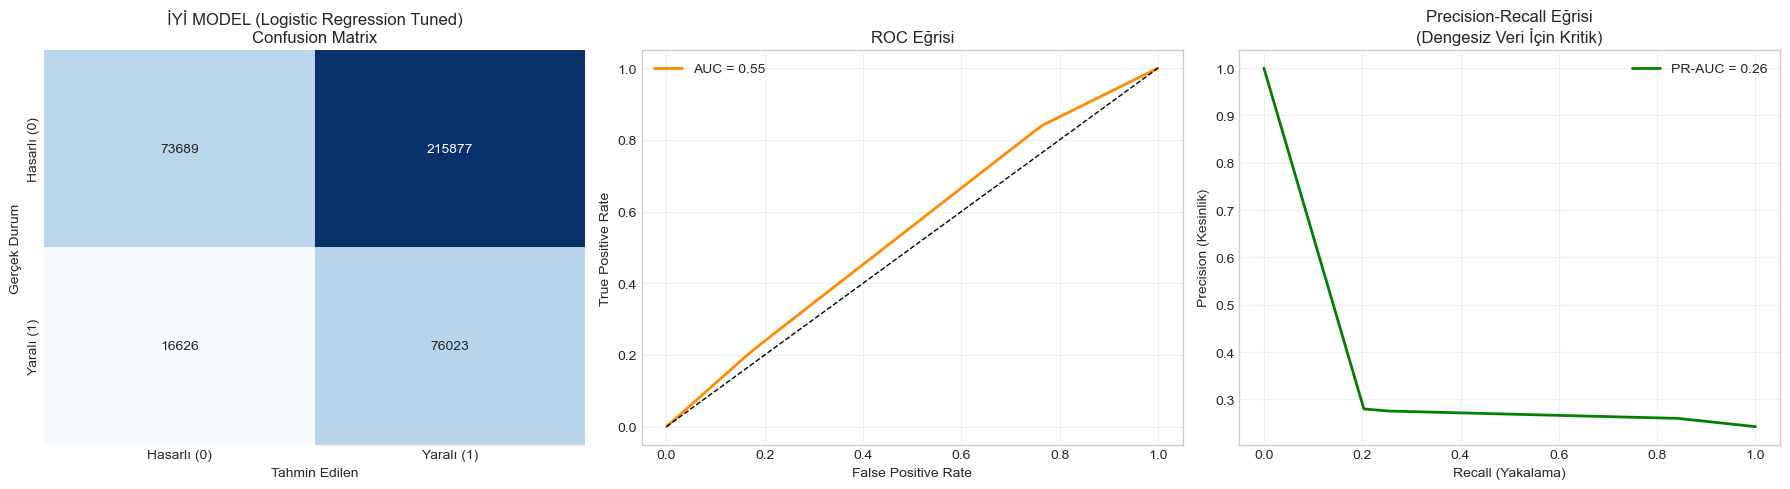

In [17]:
# --- HÜCRE 3: İYİ MODEL (THE BEST) ---
iyi_model_dosyasi = "model_kisi3_LogisticRegression_TUNED.pkl"

# En iyi sonucu veren modeli seçip, yukarıda yazdığım analiz fonksiyonuna gönderiyorum.
# Böylece grafiklerini ve detaylı skorlarını görebileceğim.
detayli_model_analizi(
    model_path=iyi_model_dosyasi, 
    model_name="İYİ MODEL (Logistic Regression Tuned)", 
    X_data=X_test_scaled,
    y_data=y_test
)


==================== BASELINE MODEL (ComplementNB) ANALİZİ BAŞLIYOR ====================
5-Fold Cross Validation (Doğrulama) yapılıyor...

BASELINE MODEL (ComplementNB) SONUÇLARI:
• Accuracy:     0.6567
• F1 Score:     0.6521
• Recall (1):   0.2550 (Yaralı Yakalama)
• Precision:    0.2753
• ROC AUC:      0.4951
• PR-AUC:       0.2476 (Dengesiz Veri Başarısı)
• 5-Fold CV:    0.6521 (+/- 0.0029)


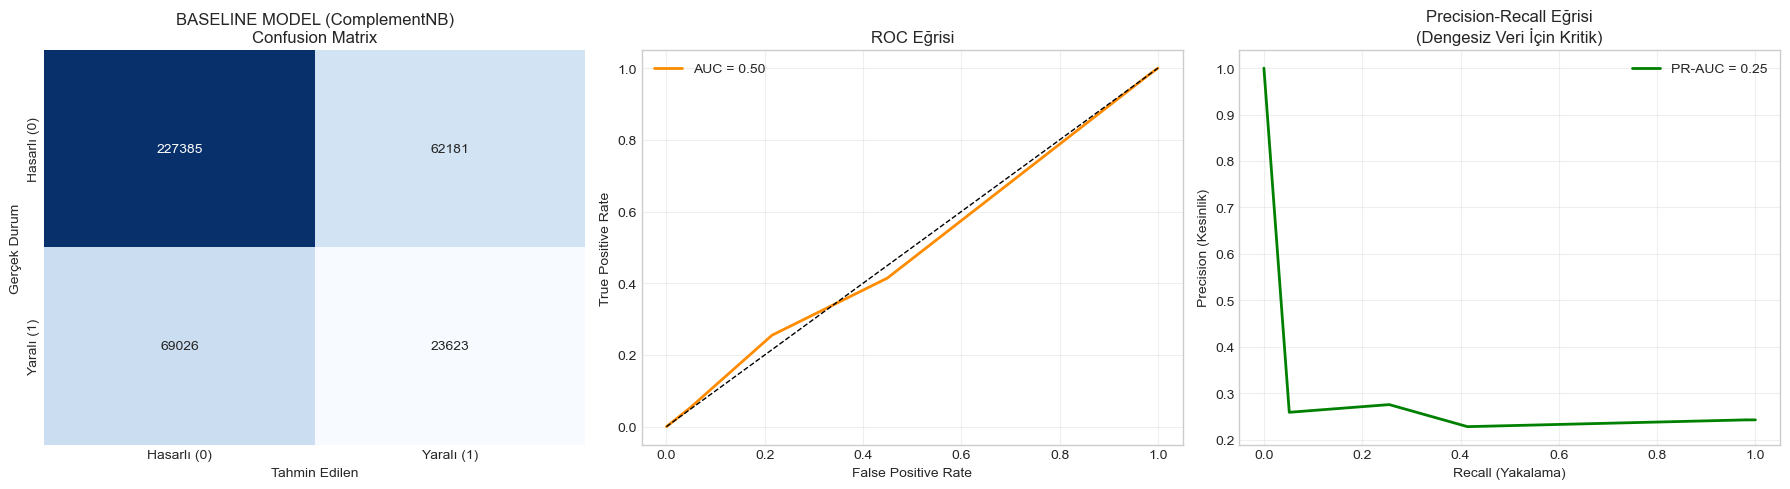

In [18]:
# --- HÜCRE 4: KIYASLAMA MODELİ (BASELINE) ---

kotu_model_dosyasi = "model_kisi3_ComplementNB.pkl"

# Kıyaslama yapabilmek için baz aldığım diğer modeli de aynı teste sokuyorum.
# Bu model ölçeklenmiş veriyi sevmediği için ona ham haldeki test verisini (X_test_raw) gönderdim
detayli_model_analizi(
    model_path=kotu_model_dosyasi, 
    model_name="BASELINE MODEL (ComplementNB)", 
    X_data=X_test_raw,
    y_data=y_test
)